<a href="https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unit A.1 - R programming and MCMC


### Example - Autoregressive processes

The following code allows to simulate from an autoregressive process. Autoregressive processes provide a simple illustration of **Markov chains** on continuous state-space.

Let $Y^{(0)} \sim N(10, 1)$ and let us define

$$
Y^{(r)} = \rho Y^{(r-1)} + \epsilon^{(r)}, \qquad \phi \in \mathbb{R},
$$

with the error terms $\epsilon^{(r)}$ being iid according to a standard Gaussian $\text{N}(0,1)$. 

Then the sequence of $Y^{(r)}$ forms indeed a Markov chain and the **transition density** is such that

$$
(y^{(r)} \mid y^{(r-1)})  \sim \text{N}(\rho y^{(r-1)}, 1).
$$ 

If the parameter $|\rho| < 1$ then the Markov chain has a more "**stable**" behaviour (i.e. the process is stationary).

In [1]:
R <- 300

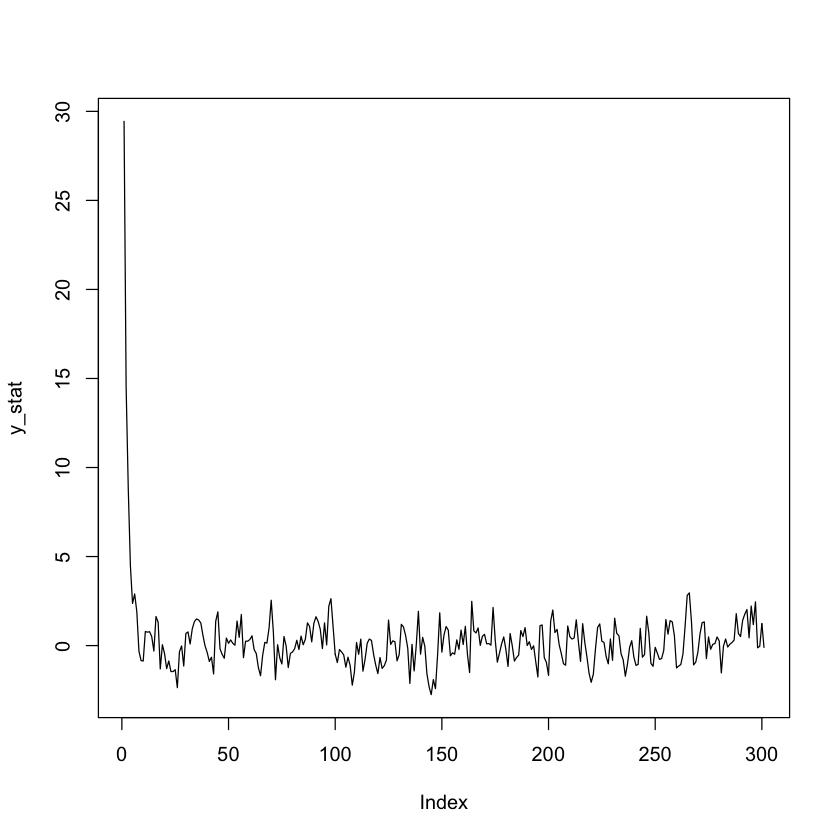

In [2]:
# Stationary process
set.seed(123)
rho <- 0.5
y_stat <- numeric(R + 1)
y_stat[1] <- rnorm(1, 30, 1)
for(r in 1:R){
    y_stat[r + 1] = rho * y_stat[r] + rnorm(1)
}

plot(y_stat, type = "l")

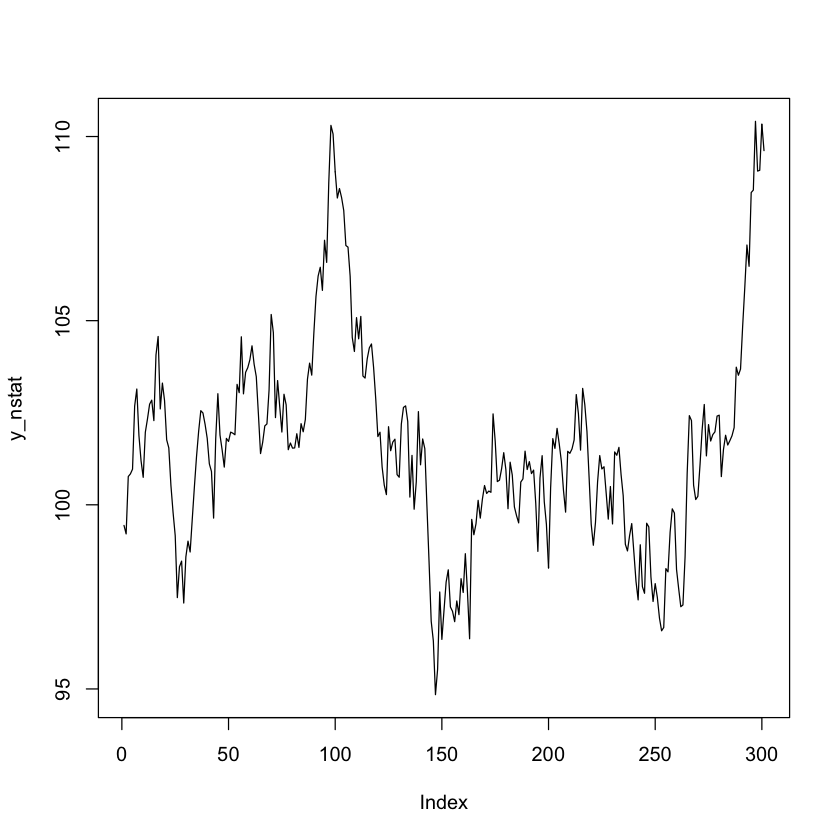

In [3]:
# Non-stationary process
set.seed(123)
rho <- 1
y_nstat <- numeric(R + 1)
y_nstat[1] <- rnorm(1, 100, 1)
for(r in 1:R){
    y_nstat[r + 1] = rho * y_nstat[r] + rnorm(1)
}
plot(y_nstat, type = "l")

In [4]:
# Open a pdf file
pdf("autoregressive.pdf", width = 10, height = 6) 
par(mfrow = c(1,2))
plot(y_stat, type = "l")
plot(y_nstat, type = "l")
dev.off()

pdf 
  2

## Gaussian example

Suppose we wish to simulate from a Gaussian distribution $\text{N}(\mu, \sigma^2)$ using a MH algorithm, whose density is $\pi(y)$.

This is obviously a **toy example**, because in practice one would just use `rnorm`.  For the proposal distribution $q(y^* \mid y)$, we can use a **uniform random walk**, namely
$$
y^* = y + u, \qquad u \sim \text{Unif}(-\epsilon, \epsilon).
$$
The choice of $\epsilon > 0$ will have an impact on the algorithm, as we shall see.

Random walks are **symmetric** proposals distributions, so $q(y^* \mid y) = q(y \mid y^*)$. This means the acceptance probability $\alpha$ is equal to
$$
\alpha(y^*, y) = \min\left\{1, \frac{\pi(y^*)} {\pi(y)}\right\}.
$$

The implementation in **R** for a generic Gaussian with mean `mu` and standard deviation `sig` is the following code. Morerover, here `x0` is the starting value and `ep` corresponds to $\epsilon$.

In [5]:
norm_mcmc <- function(R, mu, sig, ep, x0) {
    
    # Initialization
    out <- numeric(R + 1)
    out[1] <- x0
    
    # Beginning of the chain
    x <- x0
    # Metropolis algorithm
    for(r in 1:R){
        # Proposed values
        xs     <- x + runif(1, -ep, ep)
        # Acceptance probability
        alpha  <- min(dnorm(xs, mu, sig) / dnorm(x, mu, sig), 1)
        # Acceptance / rejection step
        accept <- rbinom(1, size = 1, prob = alpha)
    
        if(accept == 1) {
            x <- xs
        }
        out[r + 1] <- x
    }
    out 
}

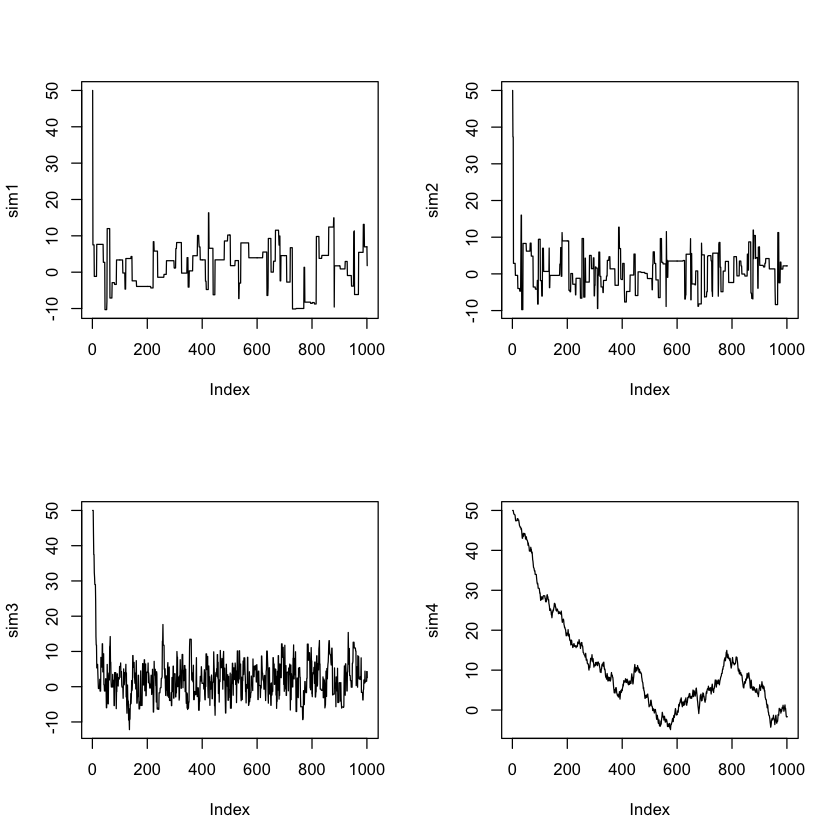

In [6]:
par(mfrow = c(2, 2))

set.seed(123)
sim1 <- norm_mcmc(1000, mu = 2, sig = 5, ep = 100, x0 = 50)
plot(sim1, type = "l")

sim2 <- norm_mcmc(1000, mu = 2, sig = 5, ep = 50, x0 = 50)
plot(sim2, type = "l")

sim3 <- norm_mcmc(1000, mu = 2, sig = 5, ep = 10, x0 = 50)
plot(sim3, type = "l")

sim4 <- norm_mcmc(1000, mu = 2, sig = 5, ep = 1, x0 = 50)
plot(sim4, type = "l")

In [7]:
pdf("traceplot_gauss.pdf", width = 10, height = 6) 
par(mfrow = c(2,2))
plot(sim1, type = "l", main = "ep = 100", ylab = "y", xlab = "iteration")
plot(sim2, type = "l", main = "ep = 50", ylab = "y", xlab = "iteration")
plot(sim3, type = "l", main = "ep = 10", ylab = "y", xlab = "iteration")
plot(sim4, type = "l", main = "ep = 1", ylab = "y", xlab = "iteration")
dev.off()

pdf 
  2

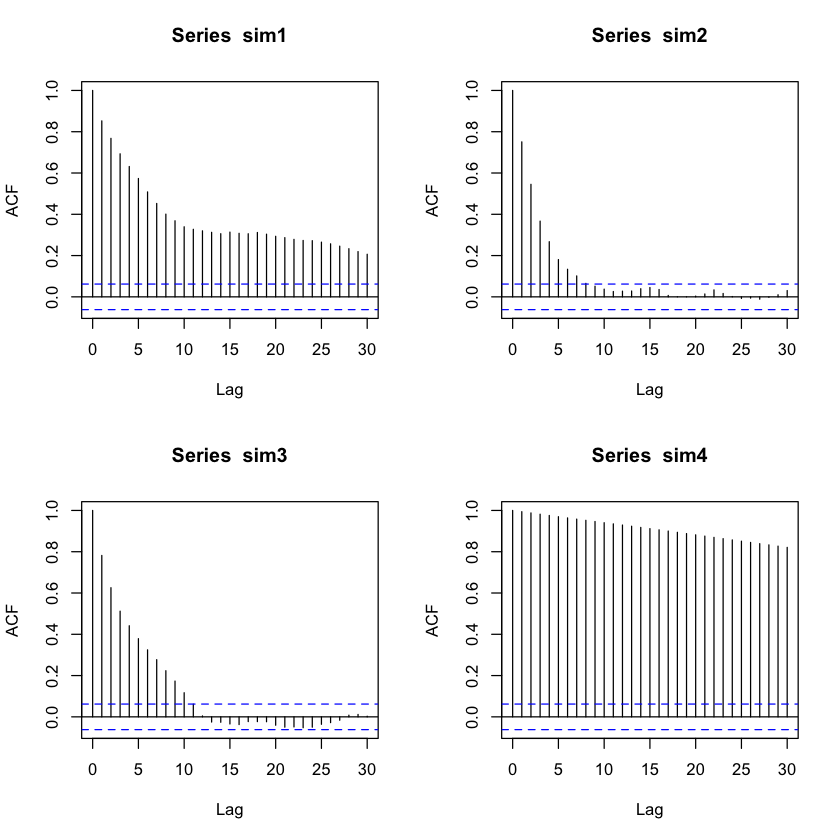

In [8]:
par(mfrow = c(2, 2))
acf(sim1)
acf(sim2)
acf(sim3)
acf(sim4)

In [9]:
pdf("auto_gauss.pdf", width = 10, height = 6) 
par(mfrow = c(2,2))
acf(sim1)
acf(sim2)
acf(sim3)
acf(sim4)
dev.off()

pdf 
  2

We choose `ep = 10`, namely the value that guarantee a good (low) auto-correlation. We now simulate a longer chain, which is compared with the nominal distribution, having omitted the burn-in period.

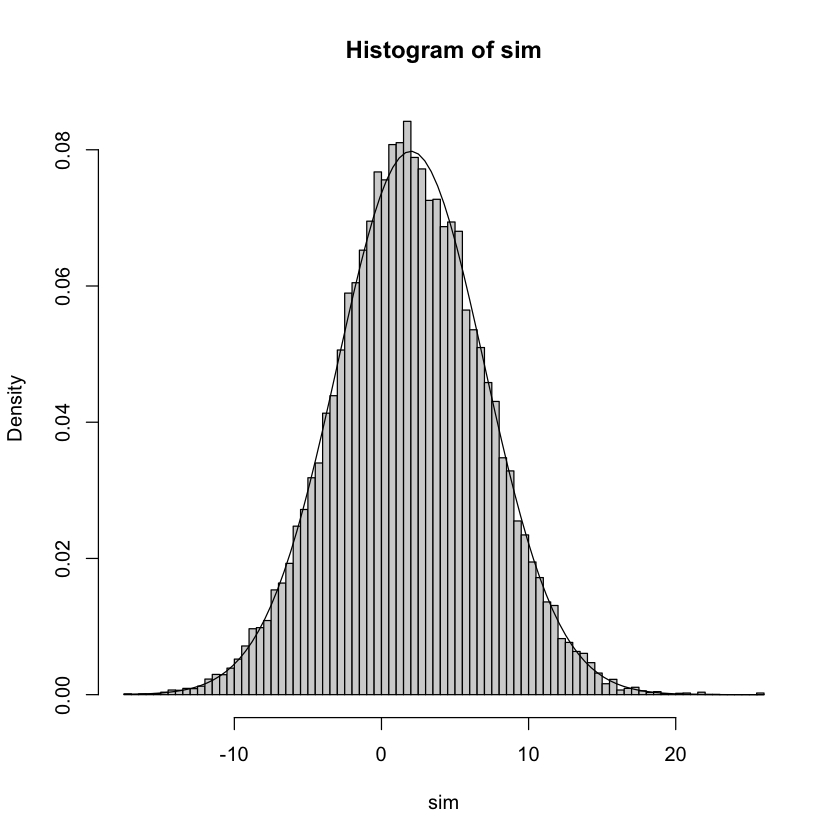

In [10]:
# Simulate the MH chain
sim <- norm_mcmc(50000, mu = 2, sig = 5, ep = 10, x0 = 50)

# Identify a burn-in period
burn_in <- 1:200
sim <- sim[-c(burn_in)]
# Plot the results
hist(sim, breaks = 100, freq = FALSE)
curve(dnorm(x, 2, 5), add = T) # This is usually not known!

In [11]:
pdf("sim_gauss.pdf", width = 10, height = 6) 
hist(sim, breaks = 100, freq = FALSE)
curve(dnorm(x, 2, 5), add = T) # This is usually not known!
dev.off()

pdf 
  2

In [12]:
pdf("auto_gauss.pdf", width = 10, height = 6) 
par(mfrow = c(2,2))
acf(sim1)
acf(sim2)
acf(sim3)
acf(sim4)
dev.off()

pdf 
  2

## The `hearth` dataset

In the following it is described an implementation of a **random walk Metropolis-Hastings** algorithm for a Weibull survival model. Please refer to the [**slides of the unit A.1**](../slides/un_A1.pdf) for a more complete description of the algorithm and the model itself. 


In first place, let us load the `stanford2` dataset, which is available in the `survival` R package. As described in the documentation, this dataset includes:

> Survival of patients on the waiting list for the Stanford heart transplant program.

See also the documentation of the `hearth` dataset for a more complete description. The survival times are saved in the `time` variable which can be either **complete** (`status = 1`) or **censored** (`status = 0`). 

Let $\textbf{t} = (t_1,\dots,t_n)^\intercal$ be the vector of the observed survival times and let $\textbf{d} = (d_1,\dots,d_n)^\intercal$ be the corresponding binary vector of censorship statuses. We load in **R** these quantities and we obtain the **Kaplan-Meier** estimate of the survival function. 


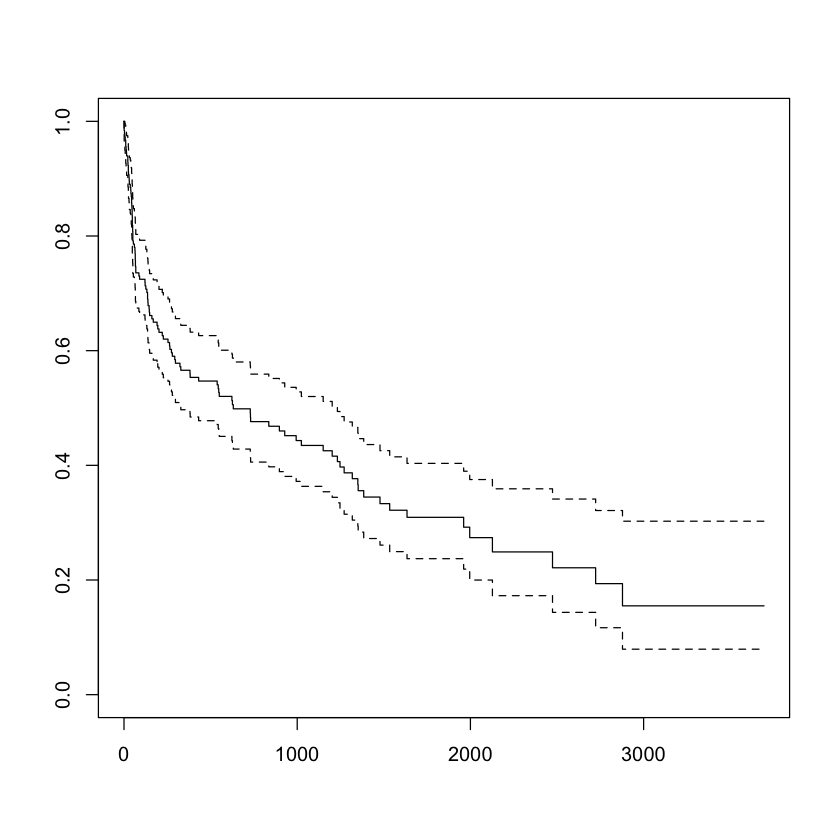

In [13]:
library(survival)
t <- stanford2$time # Survival times
d <- stanford2$status # Censorship indicator

# Kaplan-Meier estimate
fit_KM <- survfit(Surv(t, d) ~ 1)
plot(fit_KM)

### Weibull model and likelihood function

We are interested in fitting a Bayesian model for estimating the survival function and quantify the associated uncertainty. A common parametric model for survival data is the **Weibull** model, which has the following density, hazard and survival functions

$$
f(t \mid \alpha, \beta) = \frac{\alpha}{\beta}\left(\frac{t}{\beta}\right)^{\alpha - 1}\exp\left\{- \left(\frac{t}{\beta}\right)^{\alpha}\right\},
\quad h(t \mid \alpha, \beta) = \frac{\alpha}{\beta}\left(\frac{t}{\beta}\right)^{\alpha - 1},
\quad S(t \mid \alpha, \beta) = \exp\left\{- \left(\frac{t}{\beta}\right)^{\alpha}\right\}. 
$$
The likelihood for this parametric model, under suitable censorship assumptions, is the following

$$
\mathscr{L}(\alpha, \beta; \textbf{t},\textbf{d}) \propto \prod_{i=1}^n h(t_i \mid \alpha, \beta)^{d_i} S(t_i \mid \alpha, \beta) = \prod_{i : d_i=1}f(t_i \mid \alpha, \beta) \prod_{i: d_i = 0}S(t_i \mid \alpha,\beta),
$$
because $f(t \mid \alpha, \beta) = h(t\mid \alpha,\beta)S(t \mid \alpha, \beta)$. 

#### Inaccurate implementation

The above likelihood can be **naively** implemented in **R** as follows:


In [14]:
loglik_inaccurate <- function(t, d, alpha, beta) {
  hazard <- prod((alpha / beta * (t / beta)^(alpha - 1))^d)
  survival <- prod(exp(-(t / beta)^alpha))
  log(hazard * survival)
}

The log-likelihood is written in terms of products, which are numerically very unstable. Note for example that we may get `-Inf`, which is due to numerical inaccuracies. 



In [15]:
loglik_inaccurate(t, d, alpha = 0.5, beta = 1000) # As it will be clear later on, these are likely values

[1] -Inf

#### Inefficient implementations

The following two implementation are instead numerically stable but not efficient


In [16]:
# 1st inefficient implementation
loglik_inefficient1 <- function(t, d, alpha, beta) {
  n <- length(t) # Sample size
  log_hazards <- numeric(n)
  log_survivals <- numeric(n)

  for (i in 1:n) {
    log_hazards[i] <- d[i] * ((alpha - 1) * log(t[i] / beta) + log(alpha / beta))
    log_survivals[i] <- -(t[i] / beta)^alpha
  }
  sum(log_hazards) + sum(log_survivals)
}

# 2nd inefficient implementation
loglik_inefficient2 <- function(t, d, alpha, beta) {
  n <- length(t) # Sample size
  log_hazards <- NULL
  log_survivals <- NULL

  for (i in 1:n) {
    log_hazards <- c(log_hazards, d[i] * ((alpha - 1) * log(t[i] / beta) + log(alpha / beta)))
    log_survivals <- c(log_survivals, -(t[i] / beta)^alpha)
  }
  sum(log_hazards) + sum(log_survivals)
}

In [17]:
loglik_inefficient1(t, d, alpha = 0.5, beta = 1000)
loglik_inefficient2(t, d, alpha = 0.5, beta = 1000)

[1] -873.3299

[1] -873.3299

#### Accurate and efficient implementation

The following implementation is instead numerically accurate and more efficient


In [18]:
# Efficient and numerically stable version
loglik <- function(t, d, alpha, beta) {
  log_hazard <- sum(d * ((alpha - 1) * log(t / beta) + log(alpha / beta)))
  log_survival <- sum(-(t / beta)^alpha)
  log_hazard + log_survival
}

loglik(t, d, alpha = 0.5, beta = 1000)

[1] -873.3299

#### Benchmarking



In [19]:
# install.packages("rbenchmark")

In [20]:
library(rbenchmark) # Library for performing benchmarking

benchmark(
  loglik1 = loglik(t, d, alpha = 0.5, beta = 1000),
  loglik2 = loglik_inefficient1(t, d, alpha = 0.5, beta = 1000),
  loglik3 = loglik_inefficient2(t, d, alpha = 0.5, beta = 1000),
  columns = c("test", "replications", "elapsed", "relative"),
  replications = 1000
)

,test,replications,elapsed,relative
,<chr>,<int>,<dbl>,<dbl>
1,loglik1,1000,0.014,1.000
2,loglik2,1000,0.064,4.571
3,loglik3,1000,0.402,28.714


### Prior specification

Within the Bayesian framework, we need to specify also prior distributions. Since the focus of the course is on **computations** we will not explore the sensitivity to the prior and we present a single "reasonable" choice. Note that both $\alpha,\beta$ are strictly positive, therefore we could choose

$$
\theta_1 = \log{\alpha} \sim \text{N}(0,100), \qquad \theta_2 = \log(\beta) \sim \text{N}(0,100).
$$

Hence, in **R** we can define the log-prior and the log-posterior in terms of the transformed parameters $\theta = (\theta_1, \theta_2)$ as follows


In [21]:
logprior <- function(theta) {
  sum(dnorm(theta, 0, sqrt(100), log = TRUE))
}

logpost <- function(t, d, theta) {
  loglik(t, d, exp(theta[1]), exp(theta[2])) + logprior(theta)
}

## Metropolis-Hastings

We aim at obtainins (possibly correlated) samples from the posterior distribution

$$
f(\theta_1,\theta_2 \mid \textbf{t},\textbf{d}) \propto \mathscr{L}(\theta_1, \theta_2; \textbf{t},\textbf{d})f(\theta_1)f(\theta_2),
$$
recalling that $\theta_1 = \log{\alpha}$ and $\theta_2 = \log{\beta}$. This can be done using a random walk Metropolis-Hastings algorithm.

The algorithm we described is implemented in R in the following.


In [22]:
# R represent the number of samples
# burn_in is the number of discarded samples
RMH <- function(R, burn_in, t, d) {
  out <- matrix(0, R, 2) # Initialize an empty matrix to store the values
  theta <- c(0, 0) # Initial values
  logp <- logpost(t, d, theta) # Log-posterior

  for (r in 1:(burn_in + R)) {
    theta_new <- rnorm(2, mean = theta, sd = 0.25) # Propose a new value
    logp_new <- logpost(t, d, theta_new)
    alpha <- min(1, exp(logp_new - logp))
    if (runif(1) < alpha) {
      theta <- theta_new # Accept the value
      logp <- logp_new
    }
    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- theta
    }
  }
  out
}

We can now run the algorithm. We choose `R = 50000` and `burn_in = 5000`.



In [23]:
R <- 50000
burn_in <- 5000

In [24]:
# install.packages("tictoc");
# install.packages("coda");

In [25]:
library(tictoc) # Library for "timing" the functions
set.seed(123)

tic()
fit_MCMC <- RMH(R, burn_in, t, d)
toc()

1.056 sec elapsed


## Analysis of the results

### Checking the convergence


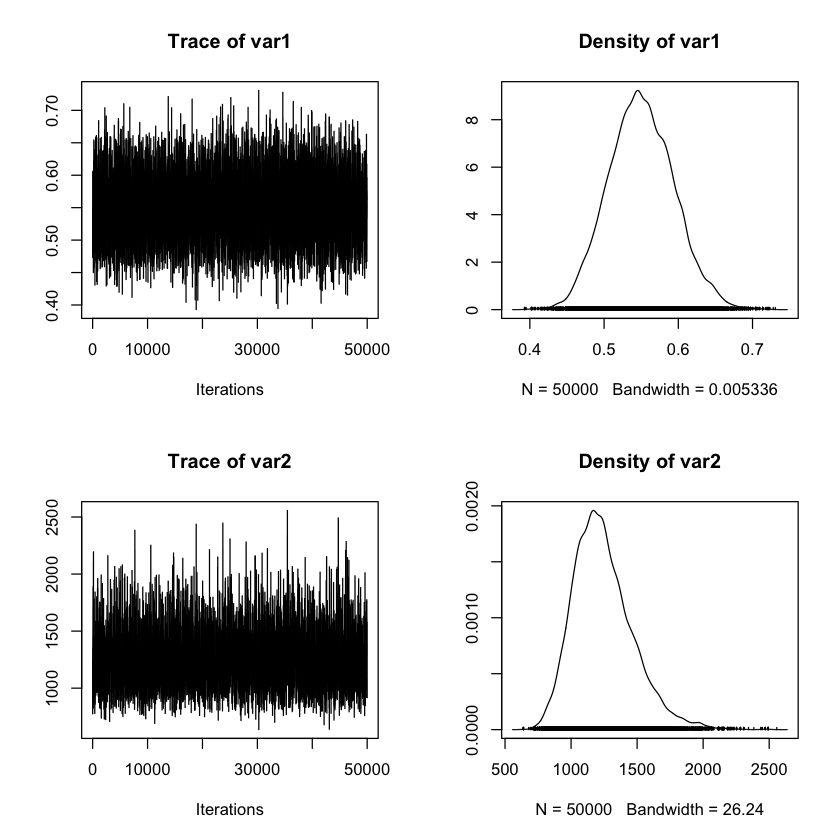

In [26]:
library(coda)
fit_MCMC <- exp(fit_MCMC) # Back to the original parametrization
fit_MCMC <- as.mcmc(fit_MCMC) # Convert the matrix into a "coda" object
plot(fit_MCMC)

In [27]:
effectiveSize(fit_MCMC) # Effective sample size
1 - rejectionRate(fit_MCMC) # Acceptance rate

var1     var2 
7325.507 3544.288

var1     var2 
0.248005 0.248005

### Estimation of the survival curve



In [28]:
# Grid of values on which the survival function is computed
grid <- seq(0, 3700, length = 50)

# Initialized the empy vectors
S_mean <- numeric(length(grid))
S_upper <- numeric(length(grid))
S_lower <- numeric(length(grid))

for (i in 1:length(grid)) {
  S_mean[i] <- mean(pweibull(grid[i], shape = fit_MCMC[, 1], fit_MCMC[, 2], lower.tail = FALSE))
  S_lower[i] <- quantile(pweibull(grid[i], shape = fit_MCMC[, 1], fit_MCMC[, 2], lower.tail = FALSE), 0.025)
  S_upper[i] <- quantile(pweibull(grid[i], shape = fit_MCMC[, 1], fit_MCMC[, 2], lower.tail = FALSE), 0.975)
}

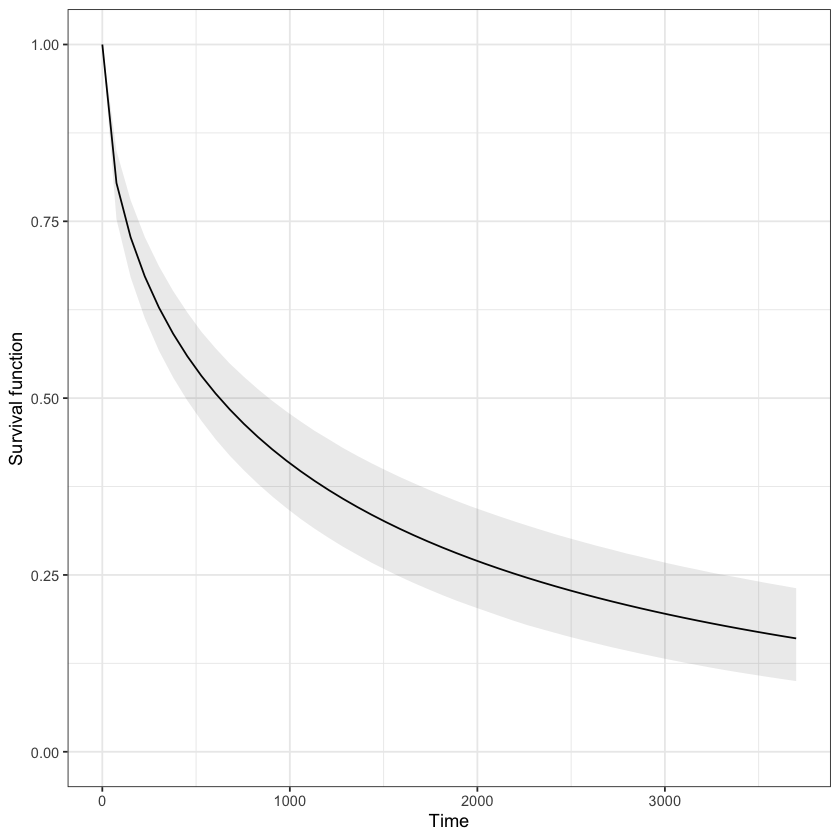

In [29]:
library(ggplot2)
data_plot <- data.frame(Time = grid, Mean = S_mean, Upper = S_upper, Lower = S_lower)
ggplot(data = data_plot, aes(x = Time, y = Mean, ymin = Lower, ymax = Upper)) +
  geom_line() +
  theme_bw() +
  ylab("Survival function") +
  ylim(c(0, 1)) +
  geom_ribbon(alpha = 0.1)
